# **Art Classifier**

## **UnStructured Data**

This project has been done by:

|Name                    |Email                              |
|------------------------|-----------------------------------|
|Jorge Ayuso Martínez    |jorgeayusomartinez@alu.comillas.edu|
|Carlota Monedero Herranz|carlotamoh@alu.comillas.edu        |
|José Manuel Vega Gradit |josemanuel.vega@alu.comillas.edu   |

The main objective of this project is building an Art Classifier leveraging Deep Learning techniques. Data is available at kaggle in the following URL: https://www.kaggle.com/datasets/sivarazadi/wikiart-art-movementsstyles. For the sake of simplicity and disk limitations in our computers, we will only be classifying 4 of the available movement styles: Romanticism, Realism, Renacentism and Baroque. 

We will first start by building a simple Deep Neural Net architecture, which will serve as our basis model for reference and comparison. We will then try to extend its capabilities by using a two-step approach:

+ First, we will increase complexity by increasing the number of hyperparameters in the network until accuracy in training set is high enough and clear signs of overfitting are observed. 
+ Secondly, we will reduce overfitting of the complex model using techniques such as upsampling using data augmentation, regularization techniques such as $L_1$, $L_2$ and dropout.

Once our custom.built model is fully explored, we will then shift our focus towards using transfer learning based on the convolutional part of an off-the-shelf pre-trained network, which we will then combine with a fully connected classifier (DNN). Depending on the achieved performance, we can potentially consider unfreezing one or two of the last convolutional layers to allow for more specific feature extraction.

# Load dependencies

First of all, let's load the required libraries in order to run the code:

In [1]:
import os
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

# Load data

Our data is downloaded from the above mentioned kaggle URL. We have saved our data in a directory called `data`, which must be located within the same folder as the execution notebooks. Within `data`, we can find two separate directories: `train`, `test` and `validation`, which contain an equal number of randomly selected images from each of the art classes selected. 

To allow for code reproducibility, we provide a script called `src/data_generation.py` which will automatically create the required directory structure. We recommend executing this code from the project folder.

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
for path in os.walk(base_dir):
    for folder in path[1]:
        if ".ipynb_checkpoints" in folder:
            os.rmdir(os.path.join(path[0], folder))

Let's also check how many images there are for each class in the training, validation and test set.

In [5]:
# Number of classes
n_classes = len(os.listdir(train_dir))
print(f"Number of classes: {n_classes}")

# Get existing classes
classes = os.listdir(train_dir)
print("Existing classes:\n")
classes

Number of classes: 4
Existing classes:



['Baroque', 'Realism', 'Renaissance', 'Romanticism']

In [6]:
# Training
print("Number of images per class in Training set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(train_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Training set:
Baroque: 4000
Realism: 4000
Renaissance: 4000
Romanticism: 4000


In [7]:
# Validation
print("Number of images per class in Validation set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(validation_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Validation set:
Baroque: 500
Realism: 500
Renaissance: 500
Romanticism: 500


In [8]:
# Test
print("Number of images per class in Test set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(test_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Test set:
Baroque: 500
Realism: 500
Renaissance: 500
Romanticism: 500


We can see that all classes are well balanced, and that we have a fair amount of data for training and validation.

It is also important to create the directory where the models will be saved:

In [9]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

## **1. Base model**

The first model we will create is a simple CNN. This will help us get a general idea of how a very simple model would perform classifying art images, and try to improve this model.

### 1.1. Model structure

Let's first create the model structure:

In [10]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                       )
         )
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 1.2. Data preprocessing

A critical step when creating these kind of models is how the input data is preprocessed. This:

* Normalize the input by dividing each pixel by its maximum value (i.e, 255).
* Define the input size, which affects to the final model.
* Batch size: this is the number of images in each batch.

In [13]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical'
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128, 4)


We can appreciate that the batches indeed have the shape we are looking for, with 128 images belonging 4 classes and having 256 by 256 pixels, using 3 channels (as we are dealing with color images).

### 1.3. Training

Let's train the model:

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 5 (i.e.: we will stop after there is no significant change in validation loss for 5 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs (in this case we chose 100), as we can be fairly sure that training will be stopped before reaching the limit.

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(os.path.join("models", "base_model.h5"), monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [16]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=125,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=15,
    callbacks = [es, mc]
      )

Epoch 1/100
 12/125 [=>............................] - ETA: 7:21 - loss: 1.3708 - acc: 0.3066

c:\Users\carlo\anaconda3\envs\venv_art\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.2409 - acc: 0.4443
Epoch 1: val_loss improved from inf to 1.16239, saving model to models\base_model.h5
125/125 [==============================] - 571s 5s/step - loss: 1.2409 - acc: 0.4443 - val_loss: 1.1624 - val_acc: 0.5052
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 1.1162 - acc: 0.5228
Epoch 2: val_loss improved from 1.16239 to 1.09172, saving model to models\base_model.h5
125/125 [==============================] - 565s 5s/step - loss: 1.1162 - acc: 0.5228 - val_loss: 1.0917 - val_acc: 0.5286
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 1.0477 - acc: 0.5556
Epoch 3: val_loss improved from 1.09172 to 1.02277, saving model to models\base_model.h5
125/125 [==============================] - 567s 5s/step - loss: 1.0477 - acc: 0.5556 - val_loss: 1.0228 - val_acc: 0.5776
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.9980 - acc: 0.5829
Epoch 4: val_lo

As was expected, training was cut after reaching 14 epochs, which means validation accuracy did not significantly improve after epoch 9, although training validation did. This means that after the last checkpoint the model was just overfitting to the data without any significant gain upon performance on unseen data.

We can load the best model found during training using the following code:

In [18]:
# load the saved model
base_model = load_model(os.path.join("models", "base_model.h5"))

### 1.4. Validation
Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

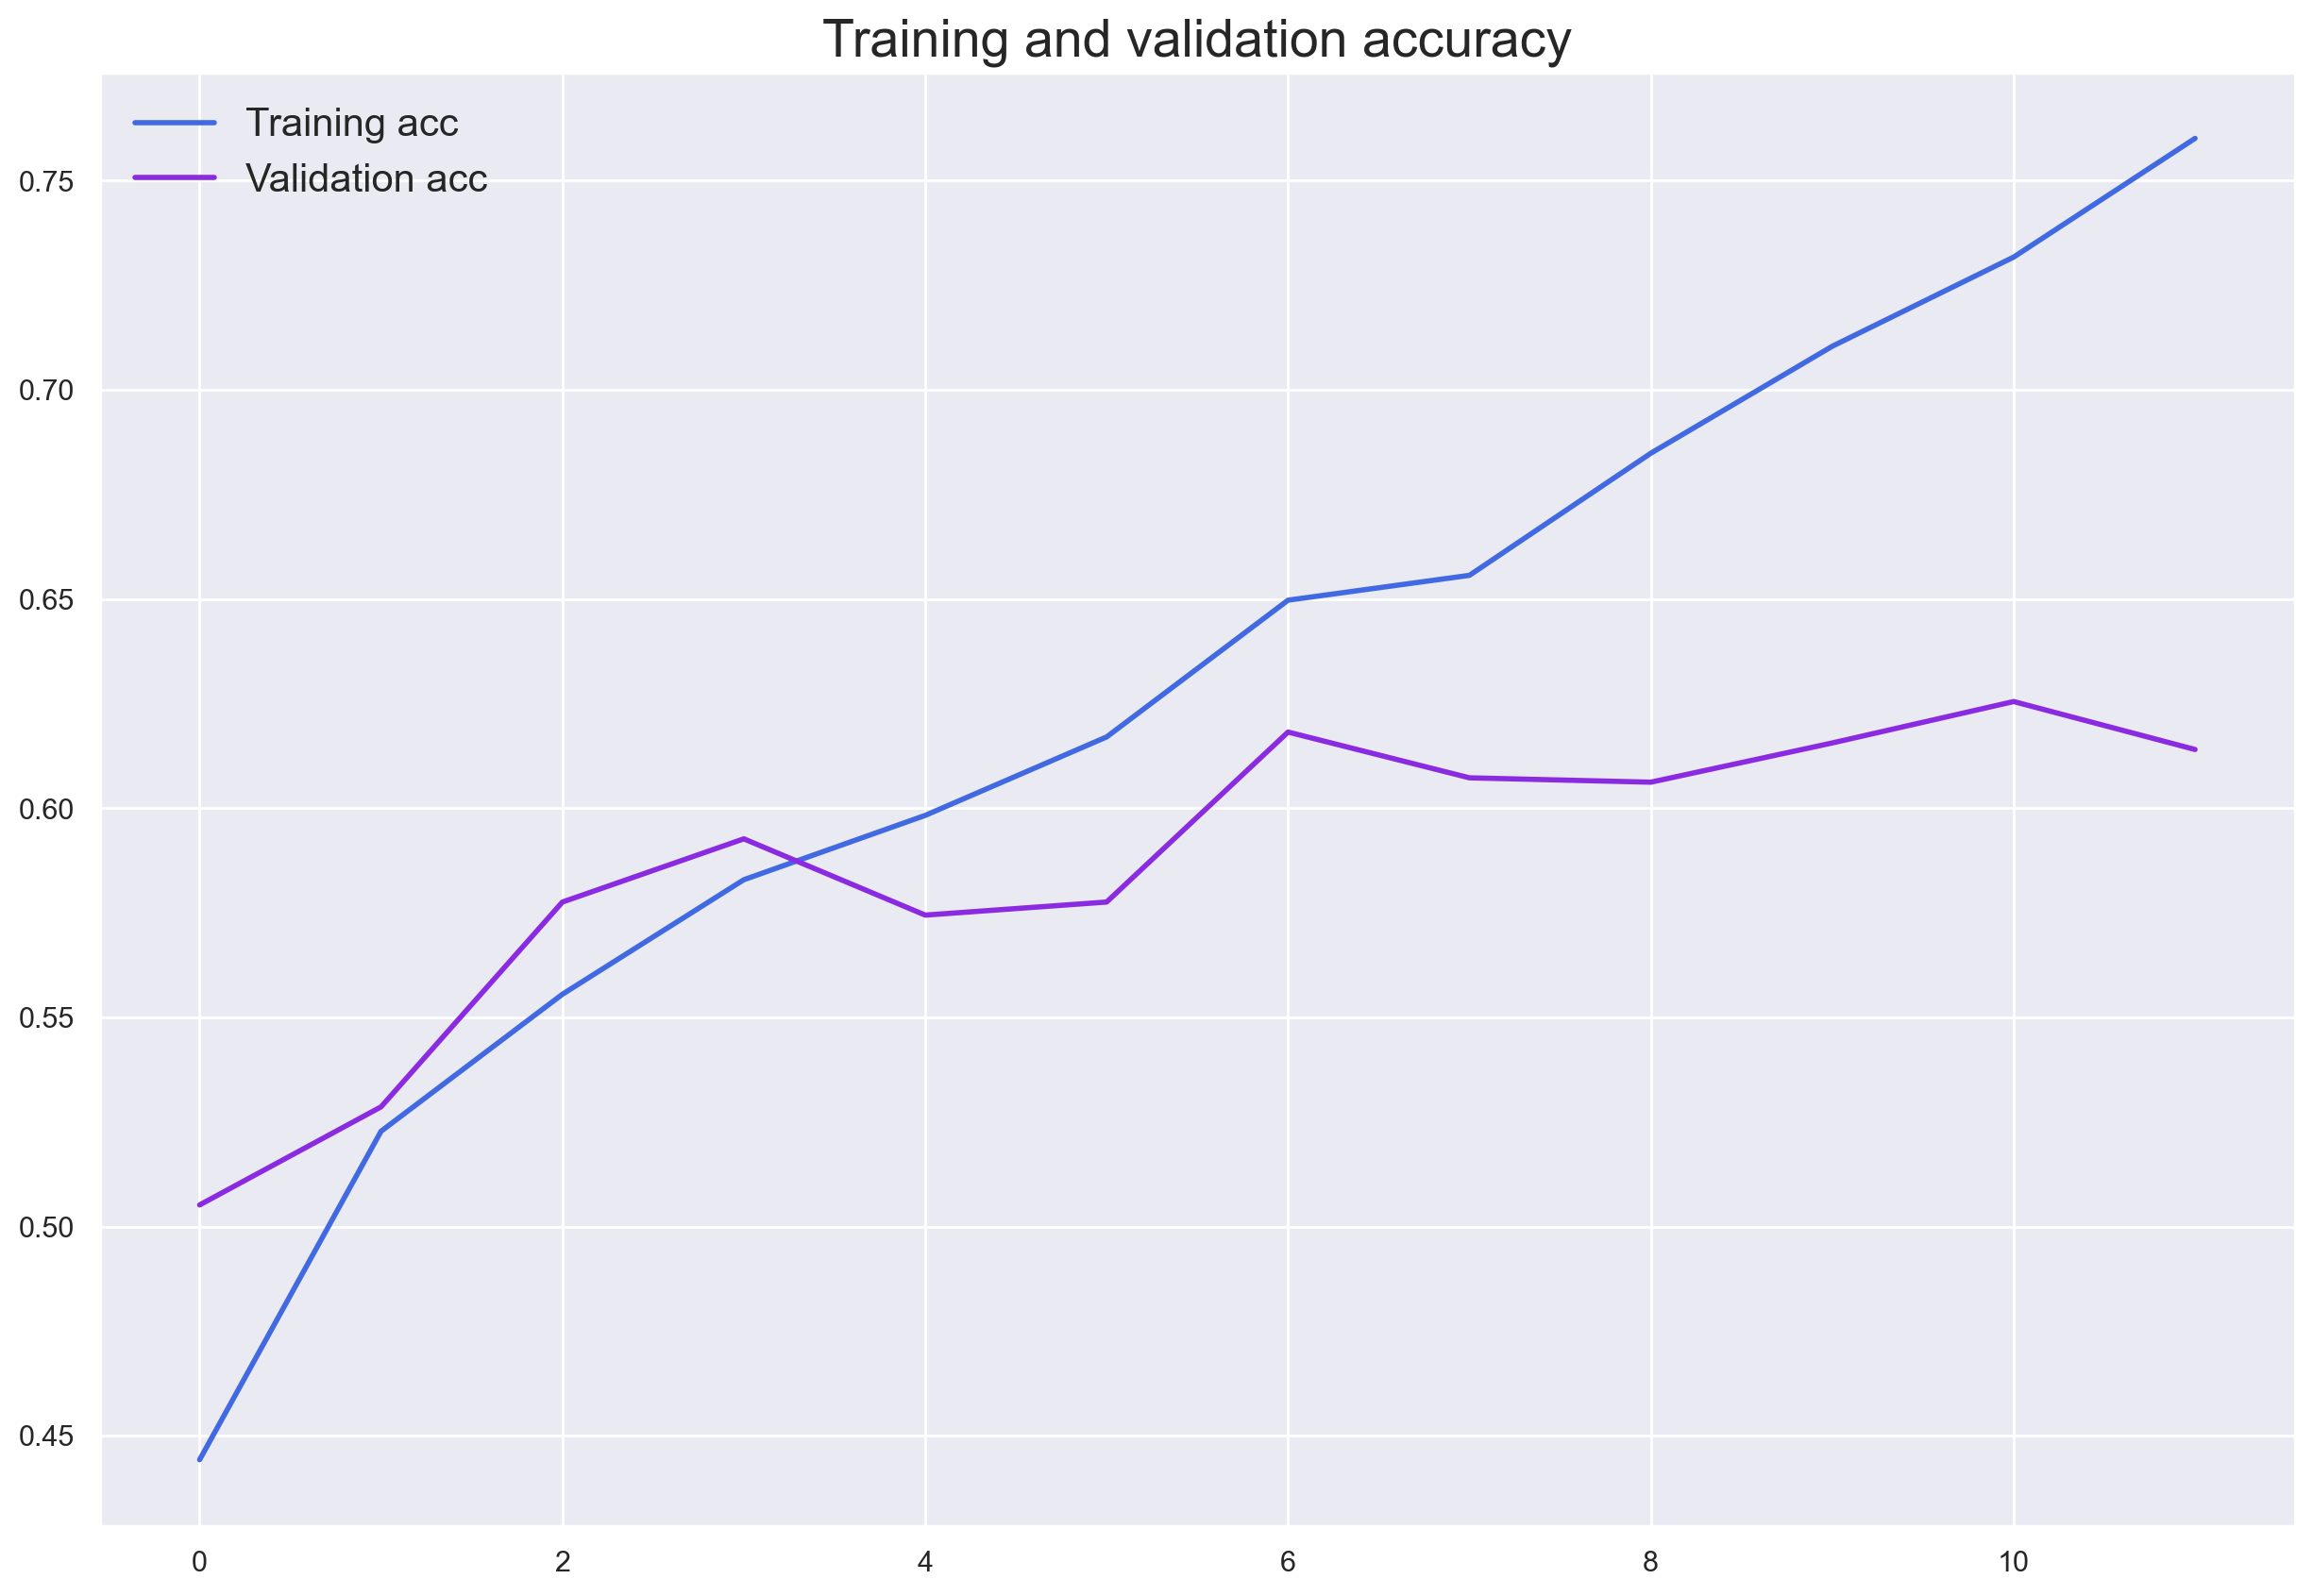

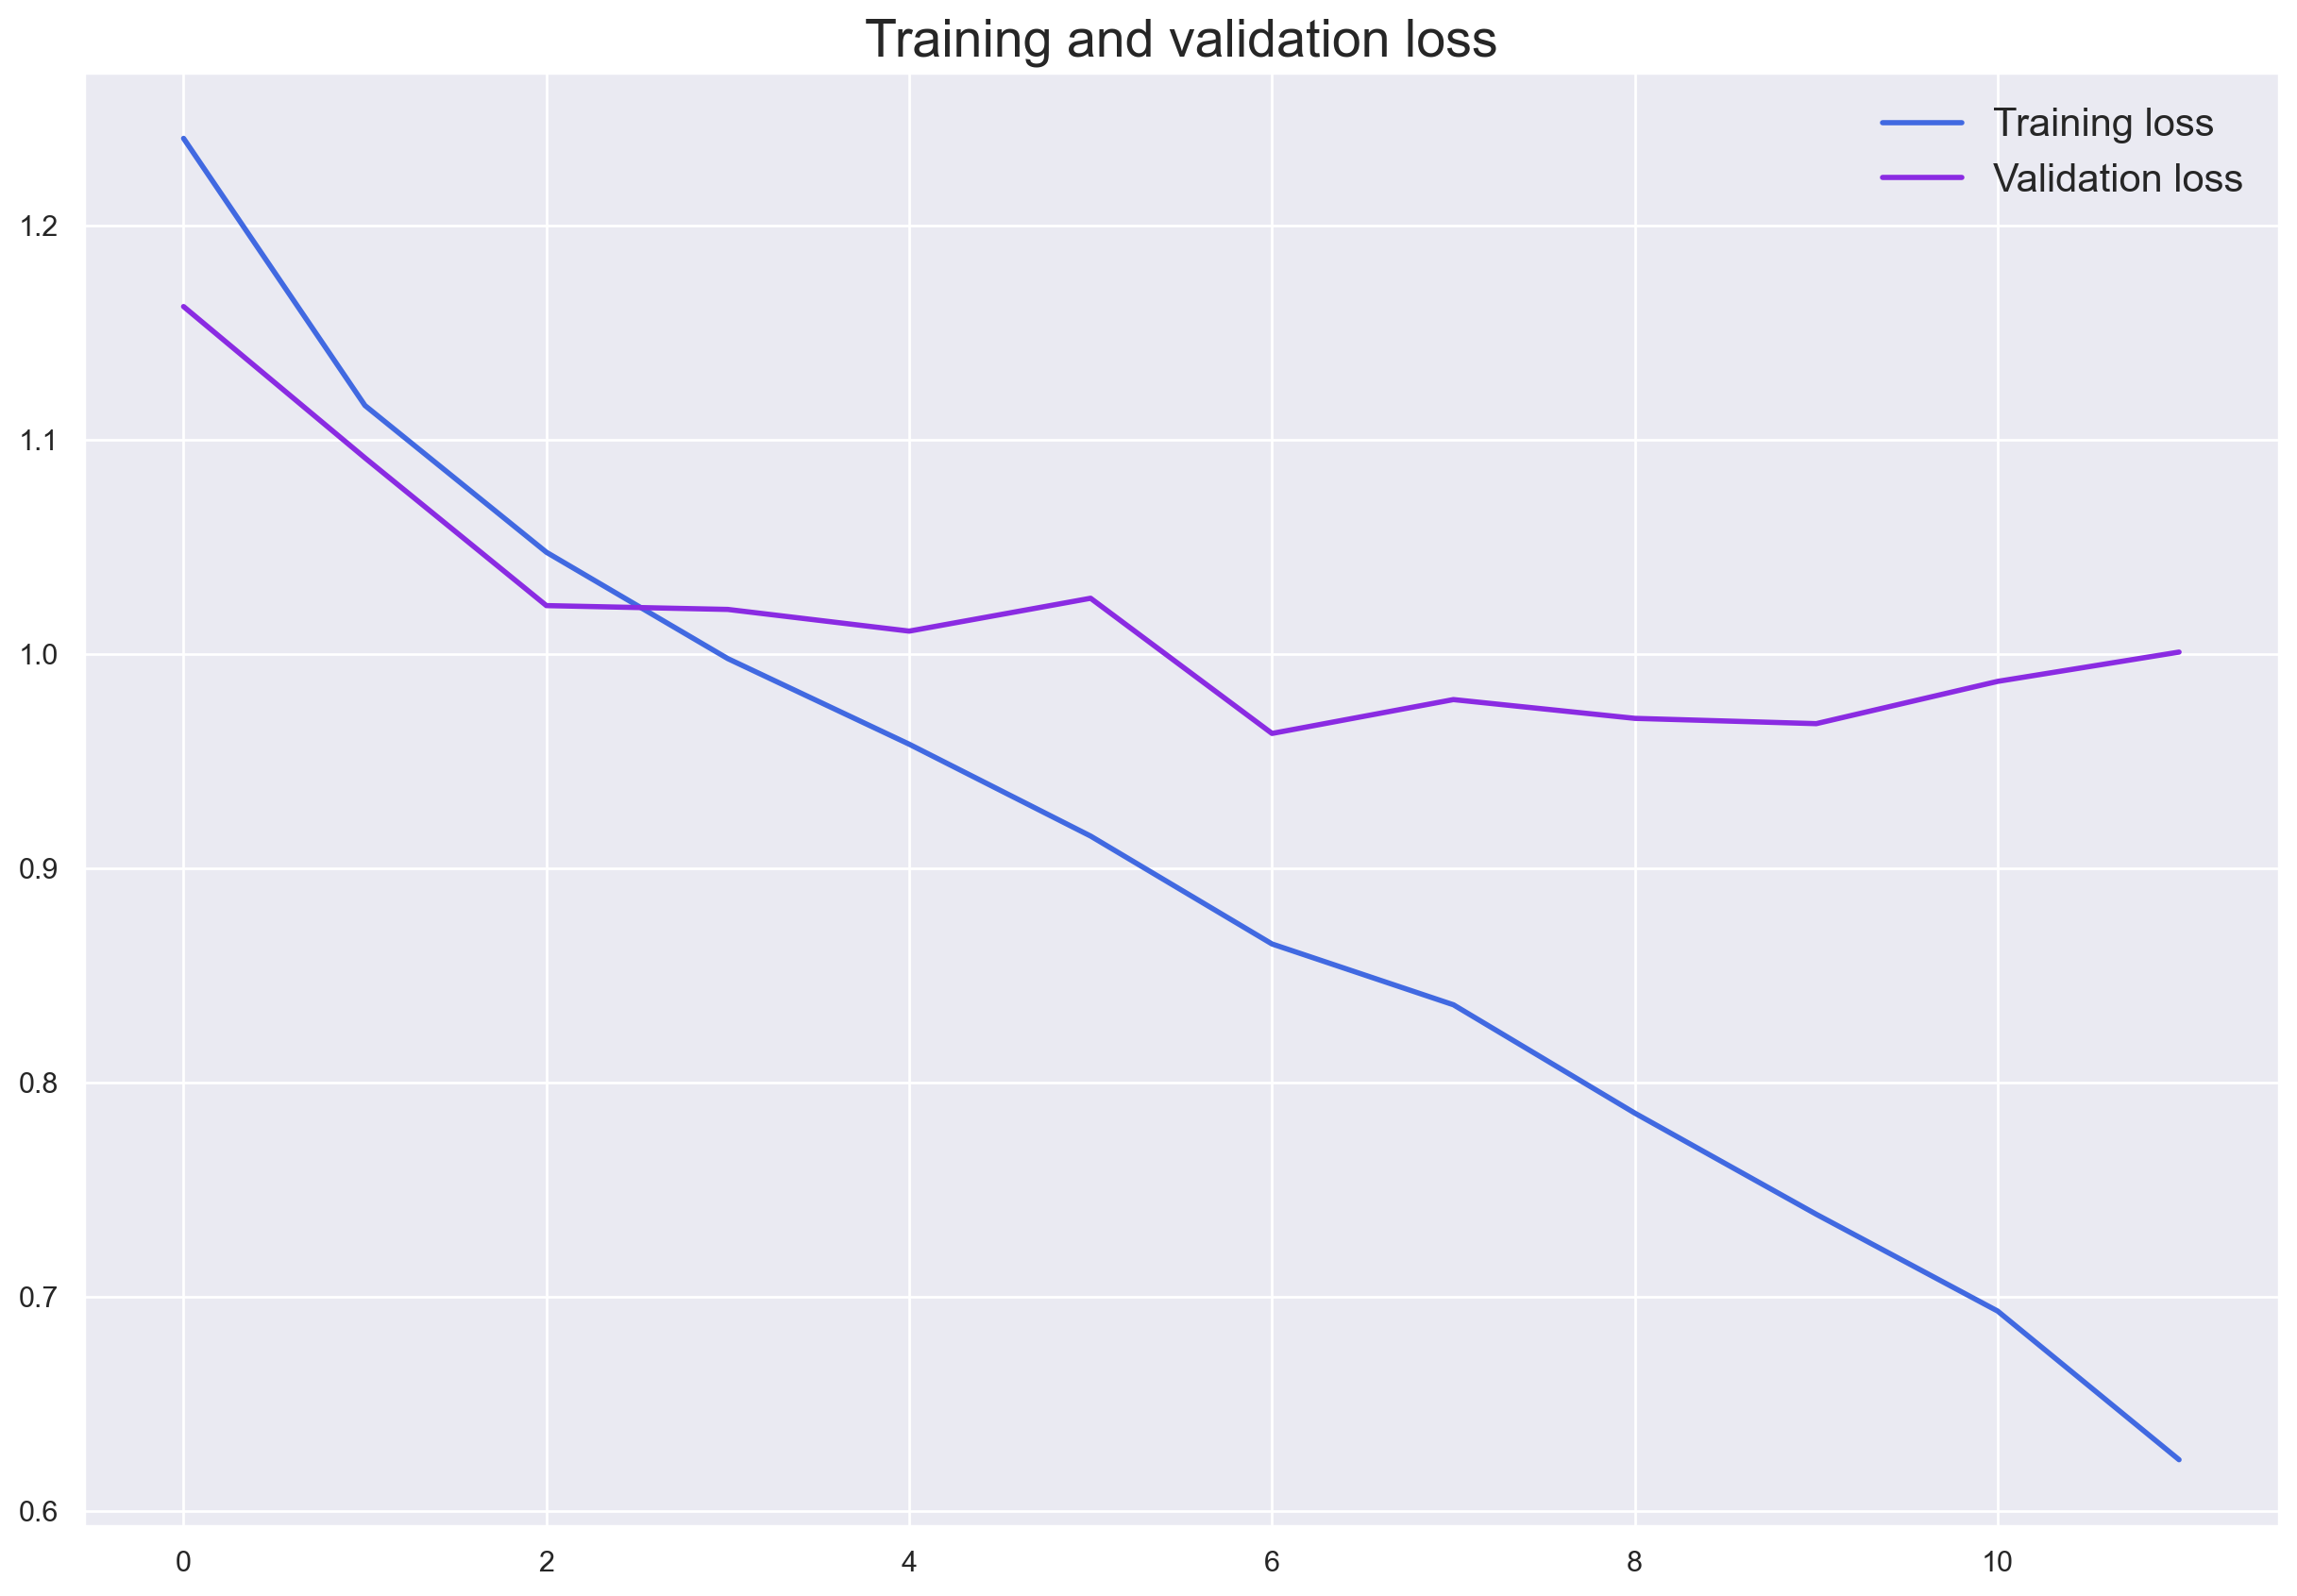

In [20]:
sns.set_theme()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, acc, 'royalblue', linewidth=2, label='Training acc')
plt.plot(epochs, val_acc, 'blueviolet', linewidth=2, label='Validation acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend(frameon=False, fontsize=15)

plt.show()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, loss, 'royalblue', linewidth=2, label='Training loss')
plt.plot(epochs, val_loss, 'blueviolet', linewidth=2, label='Validation loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend(frameon=False, fontsize=15)
plt.show()

The above plots help us visualize more clearly why early stopping decided to cut training after 12 epochs. We can observe that after training epoch 3 validation accuracy plateaus and no significant improvement is made. Similarly, validation loss function starts decreasing from this point on, while training loss keeps on decreasing at a fast pace. This means that from this point on, the model gets better at predicting training data, but without any impact on validation accuracy. 

We can also see that although the model reaches an accuracy of above 75% in the training dataset, the same cannot be said for the testing dataset, where accuracy is barely reaching 60%. This means that there are clear signs of *overfitting* to the data in the model, which call for the need for implementing regularization techniques such as dropout and data augmentation, which we will be covering in the following notebooks.